# Stochastic Simulation CW1
## Sumith Salluri (CID: 02021144)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy import integrate
from scipy.special import gammaln
from tqdm import trange

## Question 1

### Proposed Density

To choose an appropriate proposal distribution q(x) for the Banana density, we need a distribution that captures the non-linear dependency of $ x_2 \) on $ x_1 $ and has a reasonable spread to ensure efficient sampling with a high acceptance rate.

The Banana density function is given by:

$\overline{{p}}(x) = \exp \left( -\frac{x_1^2}{10} - \frac{x_2^2}{10} - 2\left(x_2 - x_1^2\right)^2 \right)$

This density has a non-linear structure where $x_2$ is strongly dependent on $x_2$. We can use a product of two Gaussian distributions with:
- $x_1 \sim \mathcal{N}(0, 5)$, which provides the right spread for $x_1$ around zero, mirroring the term $ \exp\left(-\frac{x_1^2}{10}\right)$ in the Banana density.
- $x_2 | x_1 \sim \mathcal{N}(x_1^2, (\frac{1}{2})^2) $, which makes $x_2$ centered around $x_1^2$, mirroring the term $\exp\left(-2(x_2 - x_1^2)^2\right)$ in $\overline{{p}}(x)$.

Thus, we define the proposal distribution as:
$
q(x) = \frac{1}{\sqrt{2\pi \cdot 5^2}} \exp\left(-\frac{x_1^2}{2 \cdot 5^2}\right) \cdot \frac{1}{\sqrt{2\pi \cdot \left(\frac{1}{2}\right)^2}} \exp\left(-\frac{(x_2 - x_1^2)^2}{2 \cdot \left(\frac{1}{2}\right)^2}\right).
$

Simplifying, we get:
$
q(x) = \frac{1}{2\pi \cdot 5 \cdot \frac{1}{2}} \exp\left(-\frac{x_1^2}{2 \cdot 5^2} - \frac{(x_2 - x_1^2)^2}{2 \cdot \left(\frac{1}{2}\right)^2}\right).
$


### Calculating M
$$
M = \sup \frac{p(x)}{q(x)}
$$

$$
= \frac{1}{(2 \pi \sqrt{5} \cdot \frac{1}{2})} e^{\left(-\frac{x_1^2}{10} - \frac{x_2^2}{10} - 2(x_2 - x_1^2)^2 + \frac{x_1^2}{2 \times 5} + \frac{(x_2 - x_1^2)^2}{2 \times (x_2)^2}\right)}
$$

$$
= \frac{1}{\pi \sqrt{5}} e^{-\frac{x_2^2}{10}}
$$

$$
\log M = -\frac{x_2^2}{10} - \log(\pi \sqrt{5})
$$

$$
\frac{\partial}{\partial x_2} (\log M) = -\frac{x_2}{5} = 0
$$

$$
\Rightarrow x_2 = 0
$$

$M$ is maximized at $x_2 = 0$.

We can grid search $x_1$ for the maximal $M$.


In [36]:
# Define the Banana density function
def banana_density(x1, x2):
    return np.exp(-x1**2 / 10 - x2**2 / 10 - 2 * (x2 - x1**2)**2)

# Define the proposal density q(x)
def proposal_density(x1, x2, s):
    return (2*math.pi*s[0]*s[1])**-1 * np.exp((-x1**2)/(2*s[0]**2) - (x2 - (x1**2))**2/(2*s[1]**2))

# sample
def sample_proposal(s):
    x1 = np.random.normal(0, s[0])
    x2 = np.random.normal(x1**2, s[1])
    return x1, x2
    
# Function to calculate M by finding the maximum of p(x) / q(x)
def calculate_M(s):
    x1_vals = np.linspace(-10, 10, 1000)
    max_ratio = 0

    for x1 in x1_vals:
        px = banana_density(x1, 0)
        qx = proposal_density(x1, 0, s=s)
        if qx > 0:
            ratio = px / qx
            if ratio > max_ratio:
                max_ratio = ratio
    return max_ratio

# Rejection sampling function
def rejection_sampler(N, s):
    M = calculate_M(s)
    accepted_samples = []
    total_samples = 0

    while len(accepted_samples) < N:
        # Sample from the proposal distribution q(x)
        x1, x2 = sample_proposal(s=s)
        px = banana_density(x1, x2)
        qx = proposal_density(x1, x2, s=s)

        # Acceptance condition in log-domain
        # print(px, qx)
        if px <= 0:
            continue
        if math.log(np.random.rand()) < (math.log(px) - math.log(qx) - math.log(M)):
            accepted_samples.append([x1, x2])
        
        total_samples += 1

    acceptance_rate = N / total_samples
    return np.array(accepted_samples), M, acceptance_rate

In [38]:
# Run the rejection sampler and plot the results
N = 50000
samples, m, acceptance_rate = rejection_sampler(N, s=[math.sqrt(5), 0.5])
print(f'Maximal M: {m}\nAcceptance Rate: {acceptance_rate}')

Maximal M: 7.025634452704435
Acceptance Rate: 0.5114043162524292


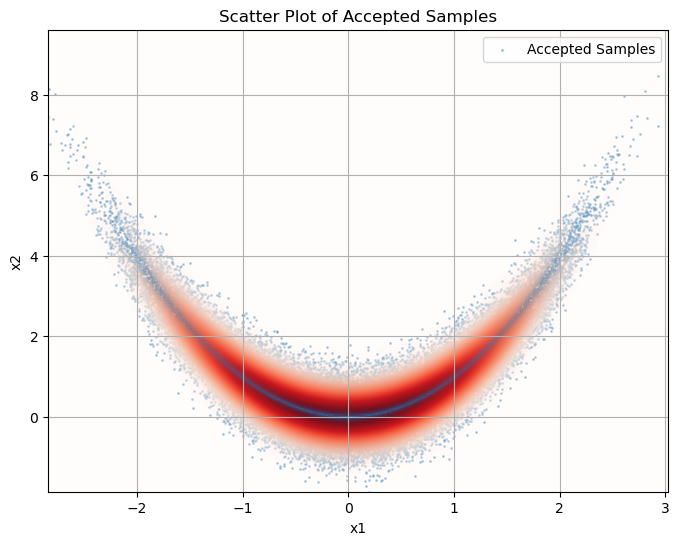

In [39]:
# Plot the scatter plot of accepted samples
plt.figure(figsize=(8, 6))

x1_vals = np.linspace(min(samples[:, 0]), max(samples[:, 0]), 300)
x2_vals = np.linspace(min(samples[:, 1]), max(samples[:, 1]), 300)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = banana_density(X1, X2)

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.4, label="Accepted Samples")
plt.contourf(X1, X2, Z, levels=500, cmap='Reds', alpha=0.2)

plt.title("Scatter Plot of Accepted Samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid()
plt.show()

As we can see the samples follow the banana distribution very well indicating the sampling is correct

In [42]:
def integrate_function(f, a, b):
    return integrate.dblquad(f, *a, *b)
z, e = integrate_function(banana_density, a=(-12, 12), b=(-12 ,12))
print(f'Integral of banana density: {z}')

Integral of banana density: 3.6013257789914386


In [44]:
print(f'Theoretical acceptance rate: {z/m}')

Theoretical acceptance rate: 0.5125979444611085


Theoretical acceptance rate $(\approx 0.5126)$ and actual acceptance rate $(\approx 0.5115)$ are very close indicating correct implementation of proposal density and sampling. Over many runs the actual acceptance rate varies in and around the theoretical rate, sometimes above and sometimes below. This makes sense due to the randomness of the sampling algorithm.

In [46]:
banana_samples = np.load('samples.npy')

In [50]:
ks_p_values = stats.ks_2samp(banana_samples, samples).pvalue
print(f'KS Score p-values {ks_p_values}')

KS Score p-values [0.11248726 0.1468286 ]


## Question 2

### SNIS estimator for the marginal likelihood
$$
p(y_{1:T}) = \int p(y_{1:T} \mid x) p(x) \, dx
$$

$$
= \frac{\int p(y_{1:T} \mid x) \, \overline{p}(x) \, dx}{Z}, \quad \text{where } Z = \int \overline{p}(x) \, dx
$$

$$
= \frac{\int \frac{p(y_{1:T} \mid x) \, \overline{p}(x)}{q(x)} \, q(x) \, dx}{\int \frac{\overline{p}(x)}{q(x)} \, q(x) \, dx}
$$

$$
\approx \frac{\frac{1}{N} \sum_{i=1}^N \frac{p(y_{1:T} \mid x_i) \, \overline{p}(x_i)}{q(x_i)}}{\frac{1}{N} \sum_{i=1}^N \frac{\overline{p}(x_i)}{q(x_i)}}
$$

$$
= \sum_{i=1}^N p(y_{1:T} \mid x_i) \, \omega_i 
$$

$$
\text{where } \omega_i = \frac{W_i}{\sum W_i}, \quad W_i = \frac{\overline{p}(x_i)}{q(x_i)}
$$

$$
\text{Now substituting: } \quad p(y_{1:T} \mid x) = \prod_{t=1}^T p(y_t \mid x)
$$

$$
p^{\text{SNIS}}(y_{1:T}) = \sum_{i=1}^N \left( \prod_{j=1}^T p(y_j \mid x_i) \right) \omega_i
$$

---

#### Gaussian

For $p_1(y_j \mid x) = \mathcal{N}(y_j; x_i, \sigma^2)$, where $\sigma^2 = 0.1$:

$$
p^{\text{SNIS}}_{Gaussian} = \sum_{i=1}^N \prod_{j=1}^T \frac{1}{\sqrt{2 \pi \cdot 0.1}} \exp\left(-\frac{(y_j - x_i)^2}{2 \cdot 0.1}\right) \cdot \omega_i
$$

$$
= \sum_{i=1}^N \prod_{j=1}^T \sqrt{\frac{5}{\pi}} \exp\left(-5 (y_j - x_i)^2\right) \cdot \omega_i
$$

$$
= \left(\frac{5}{\pi}\right)^{T/2} \sum_{i=1}^N \exp\left(-5 \sum_{j=1}^T (y_j - x_i)^2 + \log \omega_i\right)
$$

---

#### Student t

For $p_2(y_j \mid x) = \text{St}(y_j; x_i, \nu, \sigma^2)$:

$$
p^{\text{SNIS}}_{Student-t} = \sum_{i=1}^N \prod_{j=1}^T \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\nu \pi \sigma^2}} \left(1 + \frac{(y_j - x_i)^2}{\nu \sigma^2}\right)^{-\frac{\nu + 1}{2}} \cdot \omega_i
$$

$$
= \left(\frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\frac{\nu \pi}{10}}}\right)^T \sum_{i=1}^N \prod_{j=1}^T \left(1 + \frac{10 (y_j - x_i)^2}{\nu}\right)^{-\frac{\nu + 1}{2}} \cdot \omega_i
$$

In [58]:
# naive implementation
def logsumexp_naive(nums):
    return np.log(np.sum(np.exp(nums)))

# stable implementation
def logsumexp_stable(values):
    max_val = np.max(values)
    return max_val + np.log(np.sum(np.exp(values - max_val)))

In [60]:
# Test with large values
test_arr = np.array([1000, 1010, 1002])

n = logsumexp_naive(test_arr)
print('naive logsumexp', n)
s = logsumexp_stable(test_arr)
print("stable logsumexp", s)

naive logsumexp inf
stable logsumexp 1010.000380790048


C:\Users\sumit\AppData\Local\Temp\ipykernel_8868\1801521852.py:3: RuntimeWarning: overflow encountered in exp
  return np.log(np.sum(np.exp(nums)))


Runtime overflow error proves naive logsumexp is numerically unstable for as values in input array get larger whilst the stable version runs fine

### Log-SNIS transformation for numerical stability:

#### Gaussian

$$
\log p^{\text{SNIS}}_{\text{Gaussian}} = \frac{T}{2} \log \frac{5}{\pi} + \text{LSE}\left(-5 \sum_{j=1}^T (y_j - x_i)^2 + \log \omega_i\right)
$$

Alternatively:

$$
\log p^{\text{SNIS}}_{\text{Gaussian}} = \frac{T}{2} (\log5 - \log{\pi}) + \text{LSE}\left(-5 \sum_{j=1}^T (y_j - x_i)^2 + \log W_i\right) - \text{LSE}\left(\log W_i\right)
$$

---

#### Student t

$$
\log p^{\text{SNIS}}_{\text{Student-t}} = T \log \Gamma\left(\frac{\nu + 1}{2}\right) - T \log \Gamma\left(\frac{\nu}{2}\right)
- \frac{T}{2} (\log(\pi) + \log(\nu) - log(10))
$$

$$
+ \text{LSE}\left(\log \omega_i - \frac{\nu + 1}{2} \log\left(\sum_{j=1}^T \left(1 + \frac{10 (y_j - x_i)^2}{\nu}\right)\right)\right)
$$

Alternatively:

$$
\log p^{\text{SNIS}}_{\text{Student-t}} = \dots (\text{prefix}) \dots + \text{LSE}\left(\log W_i - \frac{\nu + 1}{2} \log\left(\sum_{j=1}^T \left(1 + \frac{10 (y_j - x_i)^2}{\nu}\right)\right)\right) - \text{LSE}(\log W_i)
$$

These alternate versions allow us to build a list of weights while iterating samples of x and normalise at the end.

In [64]:
def log_banana_density(x):
    return -x[0]**2 / 10 - x[1]**2 / 10 - 2 * (x[1] - x[0]**2)**2

def log_proposal_density(x, s):
    return - (x[0]**2)/(2*s[0]**2) - (x[1] - (x[0]**2))**2/(2*s[1]**2) - np.log(2 * np.pi * s[0] * s[1])

In [90]:
# Load data
x_samples = np.load("samples.npy")
y_data = np.load("y.npy")

N, T = len(x_samples), len(y_data)

sigma_sq = 0.1
sigma = np.sqrt(sigma_sq)
proposal_s = [math.sqrt(5), 1/2]
nu=5

def calc_weight(x):
    log_prior = log_banana_density(x)
    log_proposal = log_proposal_density(x, proposal_s)
    log_weight = log_prior - log_proposal
    return log_weight

def snis_estimator_gauss(y_data, x_samples, lse_func=logsumexp_stable):
    log_likelihoods = []
    weights = []
    prefix = T/2 * (np.log(5) - np.log(np.pi))
    
    for x in x_samples:
        log_weight = calc_weight(x)
        
        log_likelihoods.append(log_weight - 5 * np.sum((y_data - x[0])**2))
        weights.append(log_weight)
    
    lse = lse_func(log_likelihoods)
    lse_w = lse_func(weights)
    
    return prefix + lse - lse_w

def snis_estimator_student_t(y_data, x_samples, v=nu, lse_func=logsumexp_stable):
    log_likelihoods = []
    weights = []
    T = len(y_data)
    
    # Parts outside the LSE
    log10 = np.log(10)
    logpi = np.log(np.pi)
    lognu = np.log(v)
    log_gamma_nu_plus = gammaln((v + 1) / 2)
    log_gamma_nu = gammaln(v / 2)
    prefix = T * (log_gamma_nu_plus - log_gamma_nu - (1 / 2) * (logpi + lognu - log10))
    
    for x in x_samples:
        log_weight = calc_weight(x)
        
        log_terms = np.sum(np.log(1 + (10 * (y_data - x[0])**2) / v))
        log_likelihood = log_weight - (v + 1) / 2 * log_terms
        
        log_likelihoods.append(log_likelihood)
        weights.append(log_weight)
    
    lse = lse_func(log_likelihoods)
    lse_w = lse_func(weights)
    
    return prefix + lse - lse_w

def snis_estimator(y_data, x_samples, model, v=nu, lse_func=logsumexp_stable):
    match model:
        case 'gaussian':
            return snis_estimator_gauss(y_data, x_samples, lse_func=lse_func)
        case 'student':
            return snis_estimator_student_t(y_data, x_samples, v=nu, lse_func=lse_func)
        case _:
            print('unknown model')

In [98]:
# Test runs using samples.npy and y.npy provided
print("Gaussian (naive):", snis_estimator(y_data, x_samples, model='gaussian', lse_func=logsumexp_naive))
print("Student-t (naive):", snis_estimator(y_data, x_samples, model='student', lse_func=logsumexp_naive))

print("Gaussian (stable):", snis_estimator(y_data, x_samples, model='gaussian'))
print("Student-t (stable):", snis_estimator(y_data, x_samples, model='student'))

C:\Users\sumit\AppData\Local\Temp\ipykernel_8868\1801521852.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sum(np.exp(nums)))


Gaussian (naive): -inf
Student-t (naive): -inf
Gaussian (stable): -24774.842477348193
Student-t (stable): -7574.39923590361


Here we can clearly see the naive versions failing and the stable versions giving us a useful result

In [101]:
# Experiment parameters
num_runs = 100
nu_values = np.linspace(1.5, 6.5, 20)  # 20 evenly spaced values of nu
sigma2 = 0.1
rng = np.random.default_rng()  # Random number generator
num_x_samples = 100000
rejection_sampling_s = [math.sqrt(5), 0.5]

In [90]:
# Collect results
gaussian_results = []

# Perform 100 runs for the Gaussian model
for run in trange(num_runs):
    rng = np.random.default_rng(run)
    rejection_sampled_x, _, _ = rejection_sampler(num_x_samples, rejection_sampling_s)
    log_marginal = snis_estimator_gauss(y_data, rejection_sampled_x)
    gaussian_results.append(log_marginal)

gaussian_results[:10]

100%|██████████| 100/100 [06:52<00:00,  4.12s/it]


[np.float64(-24774.895353671425),
 np.float64(-24774.823005122773),
 np.float64(-24774.845319279422),
 np.float64(-24774.727690096697),
 np.float64(-24774.873353622857),
 np.float64(-24774.834847826576),
 np.float64(-24774.81062633715),
 np.float64(-24774.910351591825),
 np.float64(-24774.855431501976),
 np.float64(-24774.821257558535)]

In [98]:
np.save('log_marginal_saves/gaussian/gaussian.npy', gaussian_results)

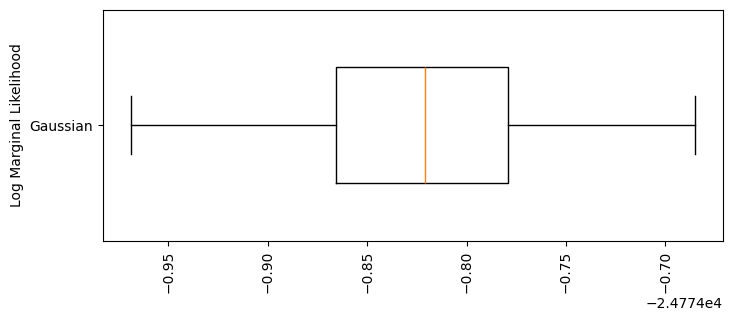

In [92]:
# Box plot visualization
plt.figure(figsize=(8, 3))
plt.boxplot([gaussian_results], positions=[0], widths=0.5, tick_labels=['Gaussian'], vert=False)
plt.xticks(rotation=90)
plt.ylabel("Log Marginal Likelihood")
# plt.tight_layout()
plt.show()

Here we can see the distribution of Gaussian log marginals over 100 runs, each with 100,000 samples of x. The mean is around $-24774.82$ and the IQR is about $[-24774.87, -24774.83]$.

In [104]:
num_x_samples = 1000

student_t_results = {nu: [] for nu in nu_values}
# Perform 100 runs for each value of nu in the Student's t model
for nu in nu_values:
    print(f'v={nu}')
    for run in trange(num_runs):
        rng = np.random.default_rng(run)
        rejection_sampled_x, _, _ = rejection_sampler(num_x_samples, rejection_sampling_s)
        log_marginal = snis_estimator_student_t(y_data, rejection_sampled_x, v=nu)
        student_t_results[nu].append(log_marginal)
    np.save(f'log_marginal_saves/student/student_v={nu}.npy', student_t_results[nu])

v=1.5


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


v=1.763157894736842


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


v=2.026315789473684


100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


v=2.2894736842105265


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


v=2.552631578947368


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


v=2.8157894736842106


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


v=3.0789473684210527


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


v=3.3421052631578947


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


v=3.6052631578947367


100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


v=3.8684210526315788


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


v=4.131578947368421


100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


v=4.394736842105263


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


v=4.657894736842105


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


v=4.921052631578947


100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


v=5.184210526315789


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


v=5.447368421052632


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


v=5.7105263157894735


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


v=5.973684210526316


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


v=6.2368421052631575


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


v=6.5


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


NOTE: Only 1000 samples of x were used for each of these student-t as it takes longer than the gaussian per run and we are iterating over many $\nu$s

In [110]:
# print({nu: vs[:10] for nu, vs in student_t_results.items()})

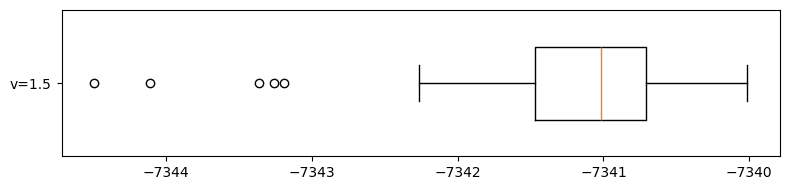

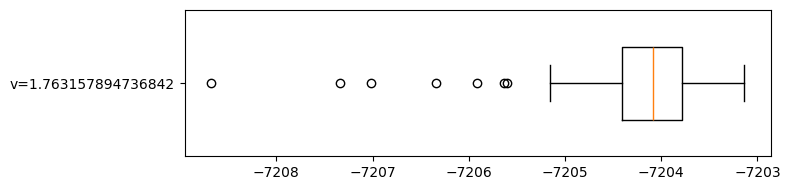

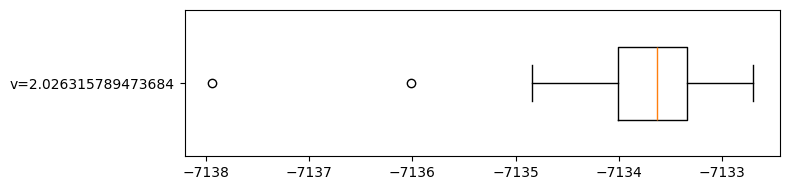

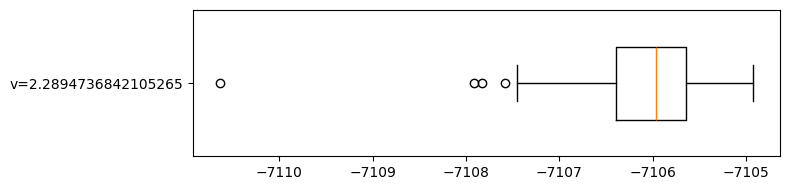

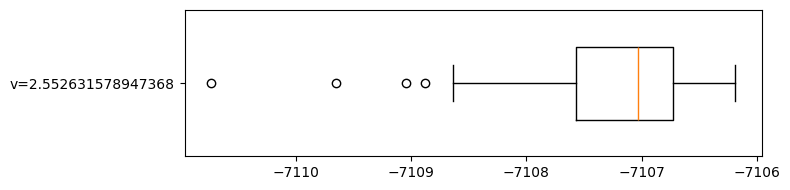

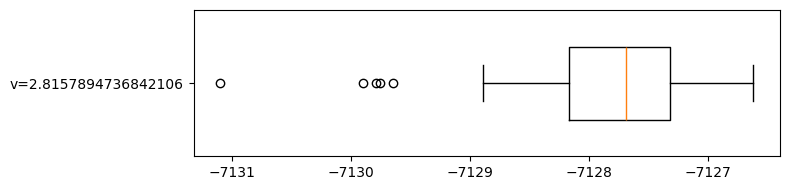

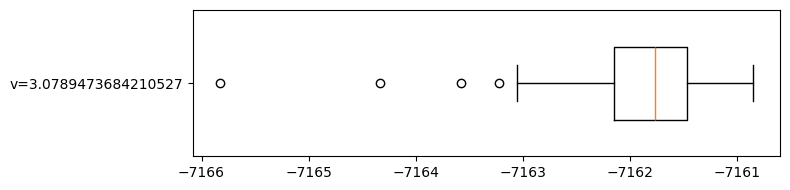

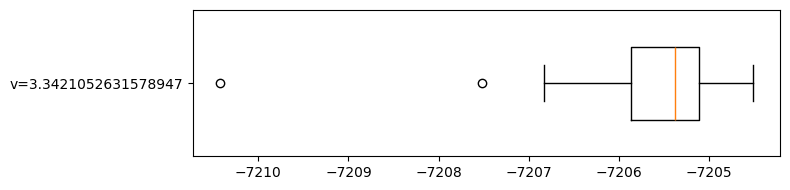

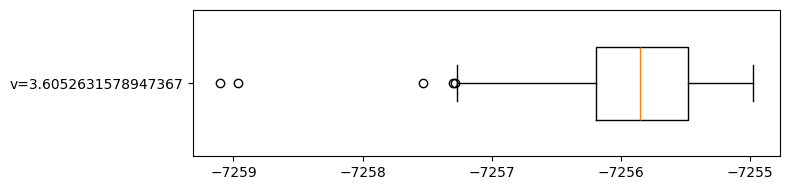

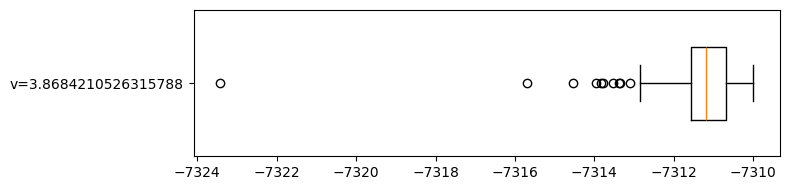

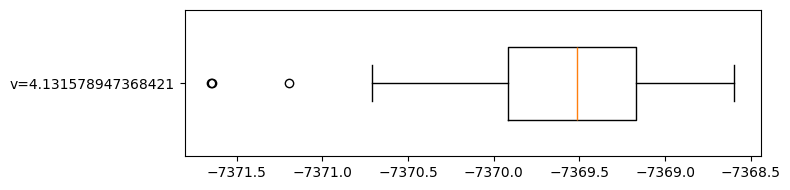

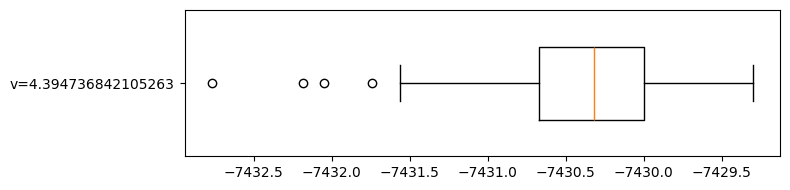

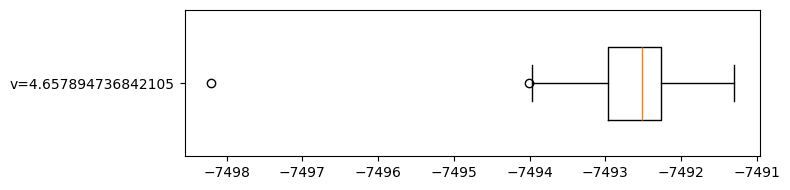

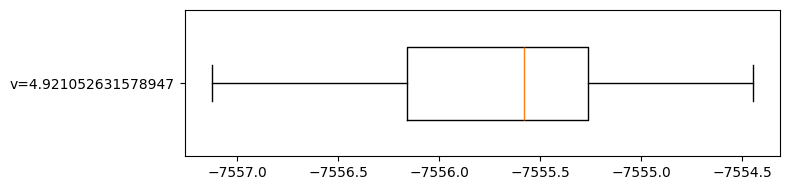

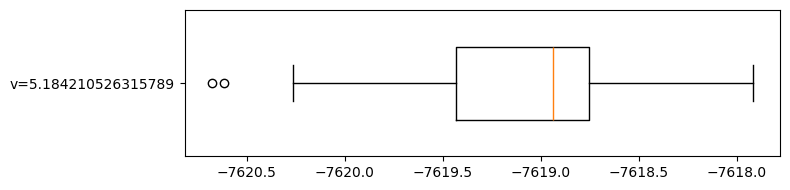

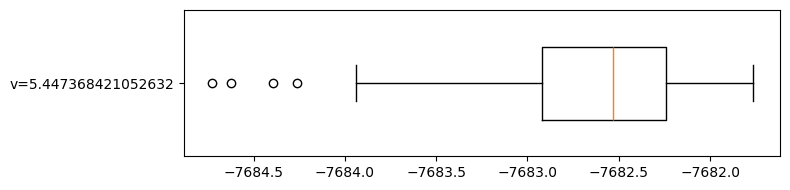

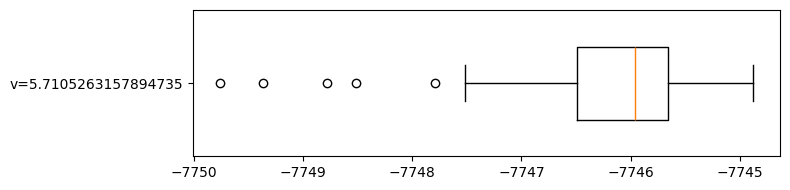

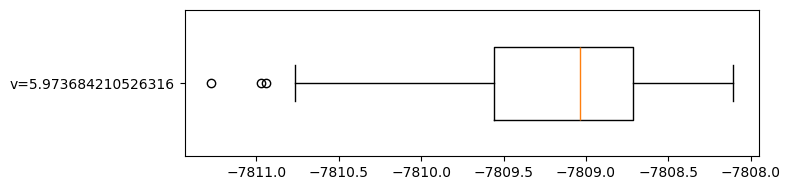

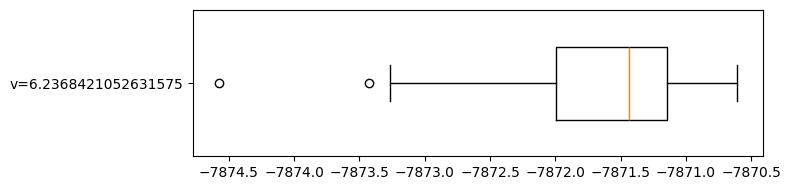

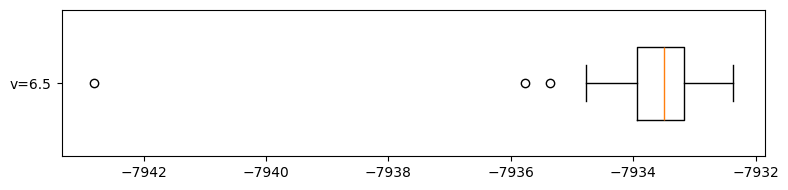

In [141]:
for i, (nu, vs) in enumerate(student_t_results.items()):
    plt.figure(figsize=(8, 2))
    plt.boxplot([vs], positions=[0], widths=0.5, tick_labels=[f'v={nu}'], vert=False)
    # ax[i % nr][i // nr].boxplot([vs], positions=[0], widths=0.5, tick_labels=[f'v={nu}'], vert=False)

    plt.tight_layout()
    plt.show()

Here are the box plots of log marginal scores for 20 $\nu$s within the range $[1.5, 6.5]$

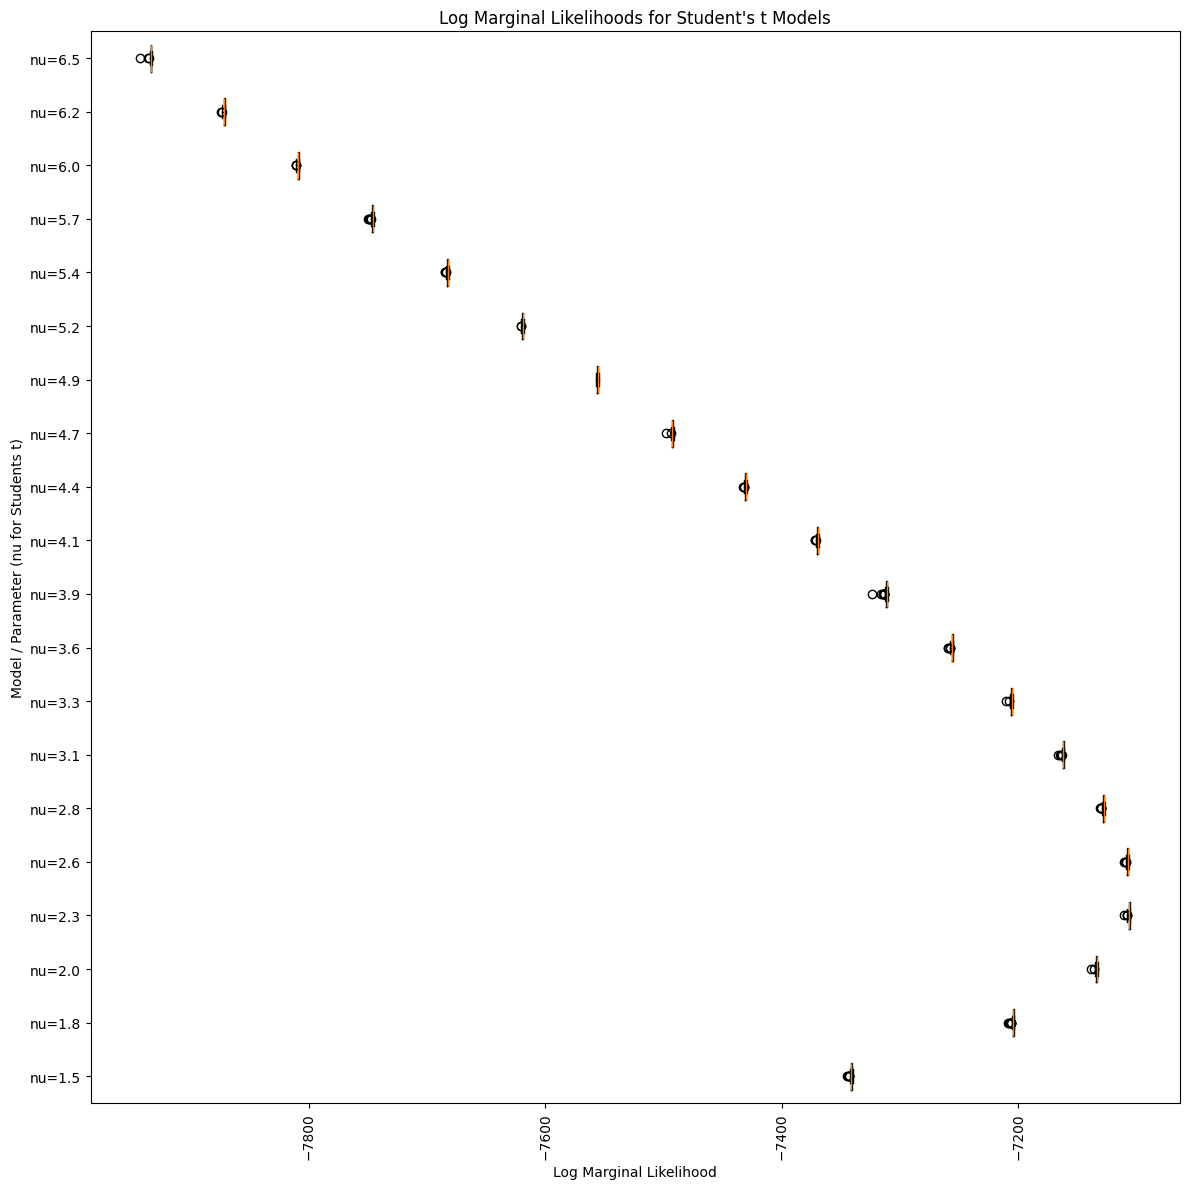

In [119]:
plt.figure(figsize=(12, 12))

# Student's t results
positions = range(1, len(nu_values) + 1)
plt.boxplot([student_t_results[nu] for nu in nu_values], positions=positions, widths=0.5, tick_labels=[f"nu={nu:.1f}" for nu in nu_values], vert=False)

plt.xticks(rotation=90)
plt.xlabel("Log Marginal Likelihood")
plt.ylabel("Model / Parameter (nu for Students t)")
plt.title("Log Marginal Likelihoods for Student's t Models")
plt.tight_layout()
plt.show()

Here we can see the log marginal means of each model over 100 runs given a $\nu$ (y-axis). We can clearly see that as $\nu$ approaches $2.6$ from above it increases, peaking at $\nu=2.3$ and decreases from $2.0$ to $1.5$. This indicates the optimal $\nu$ in the given range is around $2.3$ for the this Student-t model and fixed $\sigma=0.1^2$.

The Gaussian model had a mean of $-24774.82$ and peaked at around $-24774.68$. Even the worst Student-t model in the given range is around 3x better (in terms of log marginal score), with a worst mean of roughly $-7950$ for $\nu=6.5$. We can conclude that the Student-t model is far superior than the Gaussian.